# Fitting a computational model of momentary well-being to trial-by-trial affect ratings

During the reinforcement learning task, participants were about their subjective feelings after every trial. Specifically, after making a choice and receiving feedback, they were asked to rate from 0 to 100 how they felt with respect to three adjectives:

1. How **happy** are you at this moment?
2. How **confident** are you feeling in your answers at this moment?
3. How **engaged** are you feeling at this moment?

In each block of sixty trials, participants were asked each question exactly twenty times. The question order was randomised in groups of three such that each participant saw each question twice every six trials, and did not receive the same question more than twice in a row. Here we demonstrate that a computational model including quantities estimated from a Q-learning model fit to task choices can relatively accurately capture trial-by-trial fluctuations in affect ratings across the entire training phase.

## Setup

### Python dependencies

Despite all the code being in R, we run it through Python (via ```ryp2```) because the model outputs work better...

In [1]:
import os
os.chdir('..')
    # may need to be run initially if working directory is the notebook folder
%load_ext rpy2.ipython

### R dependencies and data

In [2]:
%%R
remotes::install_github(
    "qdercon/pstpipeline",
    quiet = TRUE,
    upgrade = "always"
)
# install.packages(c("patchwork", "ggtext"))
# cmdstanr::set_cmdstan_path("") 
# extrafont::loadfonts(device = "win", quiet = TRUE) 
    # required on Windows to load additional fonts
options(width = 120)

In [3]:
%%R
pal <- c("#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80")
pal_contr <- c("#95a7ce", "#987284", "#ffc9b5")
pal_recovery <- c("#ffc9b5", "#648767", "#b1ddf1", "#b6b8d6", "#498c8a", "#78ffd6")

all_res_split <- readRDS("data-raw/all_res_split.RDS")
all_res <- purrr::transpose(all_res_split) |> purrr::map(dplyr::bind_rows)

# install.packages("sysfonts")
# sysfonts::font_add_google("Open Sans", "Open Sans")
# showtext::showtext_auto()

## Model fits

The computational model used here is a version of one proposed and validated by Rutledge *et al.* (2014) in [PNAS](https://www.pnas.org/doi/10.1073/pnas.1407535111). This model, specifically used to capture momentary happiness, suggests that subjective well-being at a given trial can be well-captured by a discounted (i.e., recent trials weighted higher) sum of expected values and prediction errors plus a baseline weight (i.e., intercept) term. Specifically, their proposed model is as follows,

$$happiness_t = w_0 + w_1\sum_{j=1}^{t}{\gamma^{t-j}CR_j} + w_2\sum_{j=1}^{t}{\gamma^{t-j}EV_j} + w_3\sum_{j=1}^{t}{\gamma^{t-j}RPE_j},$$

where $t$ is the trial number, $\gamma$ is the discount or 'forgetting' factor, and $w$ the weights on each of the quantities of interest. It should be noted that in their task, rewards and losses were monetary, with the specific amounts won/lost available to participants on each trial, so the $EV$ and $RPE$ quantities could be calculated directly. In addition, there existed an option on each trial to take a "certain reward" ($CR$) rather than opt for a gamble.

In our task, meanwhile, expected values and prediction errors are not directly available to participants, but assumed to be computed nonetheless, with a dual learning-rate $Q$-learning model accounting well for individuals' choices. With our dataset, we were first able to answer a somewhat novel question: whether model-derived EVs and RPEs could similarly capture momentary fluctations in happiness during a reinforcement learning task. We also wondered whether fluctuations in the other affect nouns (confidence and engagement) could also be captured by such a model, perhaps with different weights. Lastly, we were interested if there may be any effect of cognitive distancing on weights estimated for each of the three affect nouns.

As affect ratings (when divided by 100) were between 0 and 1, we assumed that the $i$th ratings on each of the $p$ adjectives (i.e., happy, confident, engaged) followed independent Beta distributions with a mean-precision parameterisation, which models the shape parameters as functions of a (conditional) mean $\mu$ and precision $\phi$ [Ferrari & Cribari-Neto (2004)](https://www.tandfonline.com/doi/abs/10.1080/0266476042000214501), as validated in recent work from [Forbes & Bennett (2023)](https://osf.io/m7dtw/):

$${affect}_i \sim Beta(\mu_i\phi_p,\ (1-\mu_i)\phi_p).$$

Early versions of the model code were adapted from openly shared Stan code for a hierarchical version of the above model from an independent replication of the original PNAS study by [Vanhasbroeck *et al.* (2021)](https://www.tandfonline.com/doi/full/10.1080/02699931.2021.1891863). This was extended to incorporate the single or dual learning-rate $Q$-learning model and account for the three separate questions. 

Noting that, overall, affect ratings declined over the course of the task (e.g., due to fatigue), in a stepwise manner by block (the first rating in a block was on average highest), we included up to two extra (linear) intercept terms to account for time elapsed, both overall since the start of the task, and since the start of a given block. Such an effect has been seen in many similar studies with momentary affect ratings, and has been recently termed ["mood drift over time"](https://www.nature.com/articles/s41562-023-01519-7). The model with drift over time parameter is as follows,

$$log\left(\frac{\mu_i}{1-\mu_i}\right) = w^p_0 + w^{p}_{1}t + w_2\sum_{j=1}^{N}{\gamma^{N-j}Q_j(s_j, a_j)} + w_3\sum_{j=1}^{N}{\gamma^{N-j}[r_j - Q_j(s_j, a_j)]},$$

where $t$ is some measure of time elapsed (e.g., actual time, or block number), $N$ is the overall trial number at rating $i$ for adjective p; $Q_j$ and $r_j$ are the $Q$-learning model-derived expected values for the chosen symbol $a$ in the state $s$ (stable in this task) and the feedback valence respectively, both at trial number $j$. As before, $γ$ is the discount or ‘forgetting’ factor, and $w^p_k$ the weights on each of the $k$ quantities of interest for each adjective $p$. In contrast to model fits for the $Q$-learning model alone (in other notebooks), rewards are coded as 1 or -1, to allow for negative expected value estimates. In this model, the weight parameters are interpreted as the log odds ratio per unit change in the covariate for an increase in ${affect}_i$, with other terms held constant. Note this excludes the intercept $w_0^p$, which can simply be inverse logit transformed to the 0-1 rating scale. 

For the purposes of model comparison we fit five different variants of this model, including the original model (model 1), extended variants with constants on trial number (model 2) or block number (model 3), the passage of time model (model 4, above), and an extended model with parameters for both time elapsed overall and since the beginning of the block (model 5). We also fit the same models assuming dual learning rates (models 6-10), It should be noted that we use automatic differentiation variational inference ([ADVI](https://www.jmlr.org/papers/volume18/16-107/16-107.pdf)) implemented in CmdStan to fit these models throughout, due to the complexity making MCMC computationally unreasonable (i.e., 18 free parameters of interest for each individual, plus $Q$-learning model parameters and many other distributional parameters at the group- and individual-level). The models were compared using the leave-one-out information criterion with a correction for approximate inference implemented in the *loo* R package (see [this vignette](https://mc-stan.org/loo/articles/loo2-large-data.html)).

To improve stability of approximate fits, models were fit together in non-distanced and distanced participants, on ratings for all three questions together, with separate weights and decay factors assumed for each person and question.

#### A note on model fitting

Due to the high complexity of these models, they are non-trivial to fit, as they often get stuck in local maxima or otherwise fail to converge. In addition, the approximate fit method prevents us from exploring standard diagnostics; however, we show below that parameter recovery is generally excellent, and posterior predictions broadly accurate. 

Fitting these models required multiple attempts, with the general procedure as follows:
1. Begin model fitting and wait for the first evidence lower bound (ELBO) value to be outputted by the sampler. (In variational inference, we aim to maximise the ELBO, which is equivalent to minimising the KL-divergence between the approximate and the true posterior.) Sometimes the first negative ELBO value is extremely large, and these fits will generally not converge in a reasonable number of iterations; hence, we restart the sampler if the first ELBO value is (approximately) < -1,000,000.
2. Wait until the defined $\Delta$ ELBO tolerance is reached and the model converges (here, we have set the ```tol_rel_obj``` at 0.005, or half the Stan default). Again, this is not guaranteed, and the sampler may need to be restarted if this tolerance is not reached.
3. Check the outputted posterior distributions of the parameters &mdash; given the high complexity of the model, parameters will sometimes converge to having a posterior distribution with almost zero variance. Note that sometimes this is inescapeable, such as in the case of the $w^{b}_{1}$ parameter in the model with two time-related parameters.

### Dual learning rate models

In [4]:
%%R
head(tibble::as_tibble(all_res$ppt_info))

# A tibble: 6 × 78
  subjID                 sessionID studyID distanced exclusion final_block_AB final_block_CD final_block_EF total_points
  <chr>                  <chr>     <chr>   <lgl>         <dbl>          <dbl>          <dbl>          <dbl>        <int>
1 a82f81ad2052b1e0268e1… 6081a559… 608027… FALSE             0           0.5           0.526           0.5          4575
2 7516cf0fce1d389ff17d6… 60816b85… 60801c… FALSE             0           0.55          0.579           0.6          4625
3 b5df682d64134d13e709a… 60816cb0… 608025… FALSE             0           0.7           0.55            0.55         4600
4 3c1c4cadb651abb92bdb7… 60817da7… 608028… FALSE             0           0.5           0.8             0.8          4900
5 8fb49dbc5f64385d5a6a8… 60817829… 608027… FALSE             0           0.9           0.95            0.2          4875
6 12252bc633237e88176d8… 608177c1… 608026… FALSE             0           0.85          0.35            0.55         4375
# ℹ 69 more v

#### Original model

In [5]:
%%R
vb_affect_dual_m1 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "3wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m1"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/- 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.60749 seconds 
1000 transitions using 10 leapfrog steps per transition would take 26074.9 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 


#### Model with linear weight on trial number

In [6]:
%%R
vb_affect_dual_m2 <- pstpipeline::fit_learning_model( # issues with convergence
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_trial", vb = TRUE, tol_rel_obj = 0.005, iter = 15000, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m2"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.17487 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31748.7 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -6438793.099             1.000            1.000 
   200     -3964056.600             0.812            1.000 
   300     -2575393.00

#### Model with linear weight on block number

In [7]:
%%R
vb_affect_dual_m3 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_block", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m3"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.353 seconds 
1000 transitions using 10 leapfrog steps per transition would take 23530 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100       -24308.199             1.000            1.000 
   200       117711.524             1.103            1.207 
   300       120823.958             0.744        

#### Model with linear weight on total time elapsed (in hours)

Time elapsed was coded as hours so that the resulting coefficients were on a similar scale to other weights.

In [8]:
%%R
vb_affect_dual_m4 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_time", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.69079 seconds 
1000 transitions using 10 leapfrog steps per transition would take 26907.9 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -4373670.110             1.000            1.000 
   200     -2349460.422             0.931            1.000 
   300     -1259156.701             0.909    

#### Model with linear weights on time elapsed, in total and since the start of the block

In [9]:
%%R
vb_affect_dual_m5 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "5wt_time", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m5"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.26184 seconds 
1000 transitions using 10 leapfrog steps per transition would take 32618.4 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -2409572.607             1.000            1.000 
   200     -1722721.903             0.699            1.000 
   300     -1261294.112             0.588    

### Single learning rate models

#### Original model

In [10]:
%%R
vb_affect_single_m1 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "3wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m1"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.22948 seconds 
1000 transitions using 10 leapfrog steps per transition would take 32294.8 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -717511.745             1.000            1.000 
   200      -723010.384             0.504            1.000 
   300      -507051.187             0.478    

#### Model with linear weight on trial number

In [11]:
%%R
vb_affect_single_m2 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training",affect = TRUE, 
    affect_sfx = "4wt_trial", vb = TRUE, tol_rel_obj = 0.005, iter = 15000, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m2"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.12687 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31268.7 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -7732468.539             1.000            1.000 
   200     -5951933.876             0.650            1.000 
   300     -4344625.53

#### Model with linear weight on block number

In [12]:
%%R
vb_affect_single_m3 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_block", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m3"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.11348 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31134.8 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -1741704.791             1.000            1.000 
   200      -570954.328             1.525            2.051 
   300      -490182.573             1.072    

#### Model with linear weight on total time elapsed (in hours)

In [13]:
%%R
vb_affect_single_m4 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_time", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m4"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.12894 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31289.4 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100  -778188684418.223             1.000            1.000 
   200  -117376260027.301             3.315            5.630 
   300   -104063787.118           377.852

#### Model with linear weights on time elapsed, in total and since the start of the block

In [14]:
%%R
vb_affect_single_m5 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "5wt_time", vb = TRUE, tol_rel_obj = 0.005, iter  = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m5"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.05186 seconds 
1000 transitions using 10 leapfrog steps per transition would take 30518.6 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -784743.826             1.000            1.000 
   200      -483611.221             0.811            1.000 
   300      -324971.709             0.704    

## Model comparison

In [15]:
%%R
loo_obj_m1 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m1/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m2 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m2/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m3 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m3/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m4 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m4/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m5 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m5/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m6 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m1/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m7 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m2/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m8 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m3/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m9 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m10 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m5/fit_pst_training_2a_vb_loo_obj.RDS")

affect_mod_comp <- loo::loo_compare(
    loo_obj_m1, loo_obj_m2, loo_obj_m3, loo_obj_m4, loo_obj_m5, loo_obj_m6, loo_obj_m7, loo_obj_m8, loo_obj_m9, loo_obj_m10
)

In [16]:
%%R
print(affect_mod_comp, digits = 1, simplify = FALSE)

        elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model9        0.0       0.0  238451.9    7837.5      8359.7     342.7 -476903.7   15675.0
model8    -5896.3     635.8  232555.6    7852.7     10453.3     438.7 -465111.2   15705.4
model5    -6137.7     737.9  232314.2    7908.1      6247.2     229.8 -464628.3   15816.2
model6    -7132.6    1324.3  231319.2    8199.0      6668.8     276.3 -462638.5   16398.0
model10   -7497.0     622.2  230954.8    7945.5     13310.6     392.8 -461909.7   15891.1
model4   -12000.9     736.8  226451.0    7871.0     11052.2     301.6 -452902.0   15742.1
model3   -14097.3     766.2  224354.6    7752.9      9456.4     317.9 -448709.2   15505.8
model7   -14989.9    1537.6  223461.9    7301.7      8490.0     219.2 -446923.8   14603.4
model2   -19607.0    1477.2  218844.9    7288.1      6089.0     201.8 -437689.7   14576.2
model1   -26736.1    1318.4  211715.8    7902.2      7436.4     326.7 -423431.6   15804.5


In both groups, there is evidence from the ELPD (and the LOOIC, the ELPD on the deviance scale, i.e., multiplied by -2) that the model including a single time-related parameter &mdash; a weight on time (in hours) elapsed since the start of the task &mdash; fits the data best. The dual learning rate models are also favoured over the equivalent single learning rate model in every case.

## Check fits

#### Get posterior predictions and summaries

In [17]:
%%R
pth <- "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/"
draws_ls_4wt   <- posterior::as_draws_df(
    readRDS(paste0(pth, "fit_pst_training_2a_vb_draws_list.RDS"))
)
summary_df_4wt <- readRDS(paste0(pth, "fit_pst_training_2a_vb_summary.RDS"))
raw_df_4wt <- readRDS(paste0(pth, "fit_pst_training_2a_vb_raw_df.RDS"))

In [18]:
%%R
fits <- list()

for (adj in c("happy", "confident", "engaged")) {
    fits[[adj]] <- pstpipeline::get_affect_ppc(draws_ls_4wt, raw_df_4wt, adj = adj)
}
saveRDS(fits, "outputs/cmdstan/affect_2a/fit_dfs_all.RDS")

  |==============================================================================================================| 100%

In [19]:
%%R
fits_all <- 
    dplyr::bind_rows(
        fits$happy$fit_df |> dplyr::mutate(adj = "happy"),
        fits$confident$fit_df |> dplyr::mutate(adj = "confident"),
        fits$engaged$fit_df |> dplyr::mutate(adj = "engaged")
    )

In [20]:
%%R
library(rlang, quietly = TRUE, warn.conflicts = FALSE)
stats <- list()
for (stat in c("pseudo_R2", "MAE", "RMSE")) {
    s <- rlang::sym(stat)
    stats[[stat]] <- fits_all |> 
        dplyr::group_by(adj) |> 
        dplyr::summarise(
            n = dplyr::n(), 
            NAs = sum(is.na(!!s)), 
            median = median(!!s, na.rm = TRUE), 
            mean = mean(!!s, na.rm = TRUE),
            sd = sd(!!s, na.rm = TRUE),
            min = min(!!s, na.rm = TRUE),
            max = max(!!s, na.rm = TRUE),
            .groups = "keep"
        )
}
stats

$pseudo_R2
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd       min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>     <dbl> <dbl>
1 confident   935     3  0.417 0.424 0.234 0.000242  0.971
2 engaged     935     3  0.397 0.407 0.261 0.0000693 0.980
3 happy       935     2  0.389 0.395 0.235 0.0000189 0.942

$MAE
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd     min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>   <dbl> <dbl>
1 confident   935     0   7.07  7.92  4.28 0.00844  38.0
2 engaged     935     0   7.16  8.05  4.56 0.00417  34.2
3 happy       935     0   6.57  7.38  4.07 0.00298  33.5

$RMSE
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd     min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>   <dbl> <dbl>
1 confident   935     0   9.45 10.3   4.97 0.00846  40.6
2 engaged     935     0   9.25 10.2   5.30 0.00420  37.5
3 happy       935     0   8.59  9.38  4.74 0.00309  36

Based on predictions sampled from the approximate posterior (1,000 samples), the model is able to capture variablility in question responses relatively well, with mean ($\pm$ SD) $R^2\geq0.395~(\pm~0.2)$ for all adjectives across all participants. Considering that expected values and reward prediction errors were inferred entirely from the $Q$-learning model, as opposed to appearing on the screen as monetary amounts, this compares rather favourably to the mean $R^2=0.47~(\pm~0.21)$ originally reported by [Rutledge *et al.* (2014)](https://www.pnas.org/doi/10.1073/pnas.1407535111) in their lab-based tasks, especially when we consider our model is conservatively fit across all participants hierarchically and with approximate inference.

### Mean predictions compared to raw affect ratings

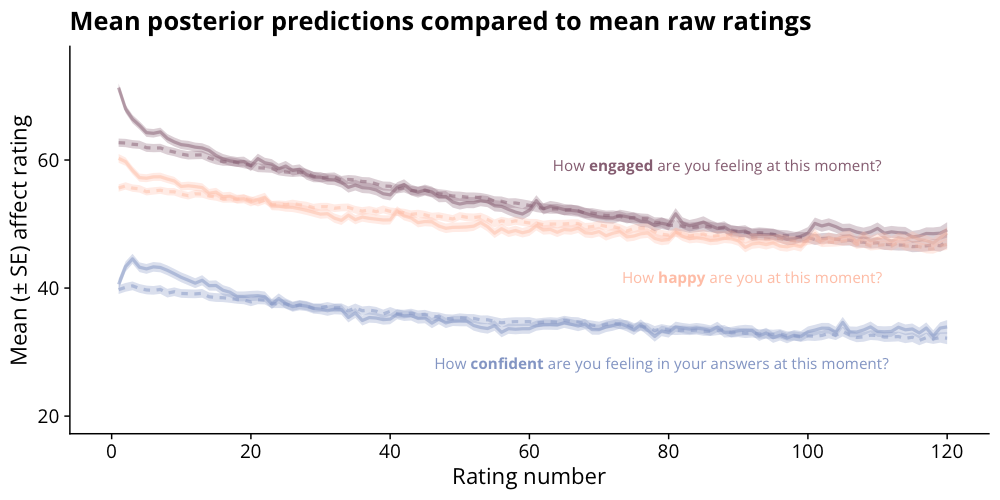

In [21]:
%%R -w 10 -h 5 --units in -r 100
fits <- readRDS("outputs/cmdstan/affect_2a/fit_dfs_all.RDS")

library(ggtext)
library(patchwork)

happ_label <- 
  "<p style='font-size:11pt; color:#ffc9b5'>How <strong>happy</strong> are you at this moment?</p>"
conf_label <- 
  "<p style='font-size:11pt; color:#95a7ce'>How <strong>confident</strong> are you feeling in your answers at this moment?</p>"
bored_label <- 
  "<p style='font-size:11pt; color:#987284'>How <strong>engaged</strong> are you feeling at this moment?</p>"

expl <- 
  "<p style='font-size:10pt; line-height:1.2; color:black'><strong>Dashed</strong> lines denote predictions sampled <br>from the approximate posterior.</p>"

ppc_plt <-
    pstpipeline::plot_affect(
        list(fits$happy, fits$confident, fits$engaged), 
        plt_type = "grouped", pal = pal_contr, font = "Open Sans", font_size = 16
    ) +
    ggplot2::scale_y_continuous(limits = c(20, 75)) +
    ggplot2::annotate("richtext", label = conf_label, y = 28, x = 79,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = happ_label, y = 41.5, x = 92,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = bored_label, y = 59, x = 87,
                      label.color = NA, family = "Open Sans") +
    ggplot2::ggtitle("Mean posterior predictions compared to mean raw ratings")
    
ppc_plt

We see here that, except for the very start of the task, the model is able to capture the overall trends in affect ratings across all three questions in both groups fairly well.

### Posterior predictions for individuals with median $R^2$

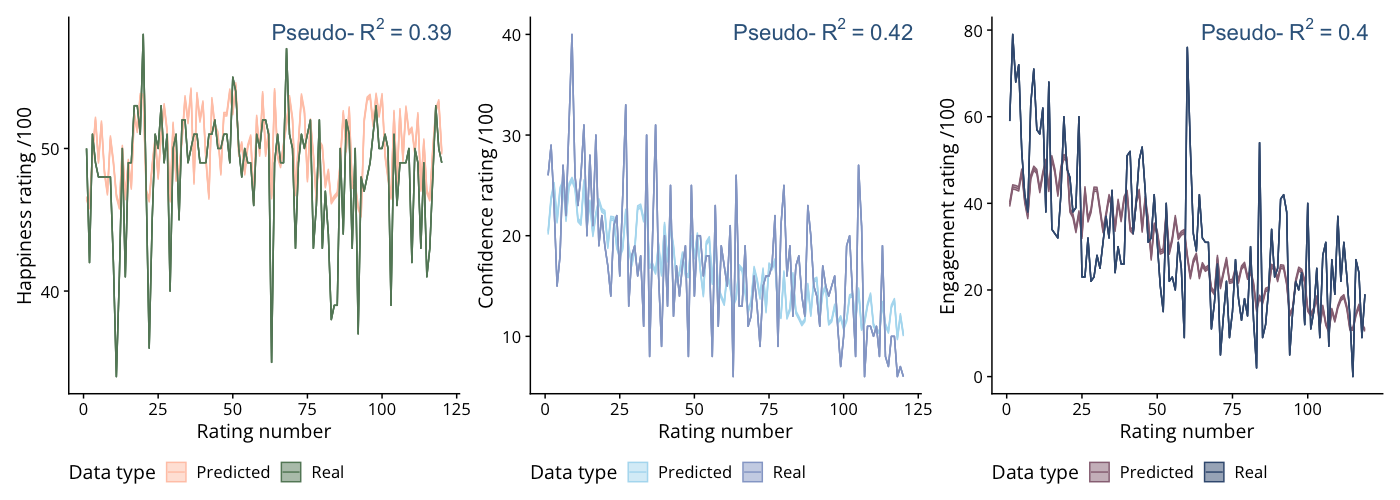

In [22]:
%%R -w 14 -h 5 --units in -r 100
library(patchwork)
med_plts <- pstpipeline::plot_affect(
    fits, plt_type = "individual", pal = pal, font = "Open Sans", 
    font_size = 14, legend_pos = "bottom", r2_coords = c(0.75, 0.97)
)
med_plts$happy + med_plts$confident + med_plts$engaged

Here are some example traces of individuals with median $R^2$ for each of the three affect adjectives, showing that the model is capturing a relatively good amount of variations in their trial-to-trial fluctuations.

### Get parameter values and plot weights

In [23]:
%%R
# pth <- "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/"
# summary_df_4wt <- readRDS(paste0(pth,"fit_pst_training_2a_vb_summary.RDS"))
# raw_df_4wt <- readRDS(paste0(pth, "fit_pst_training_2a_vb_raw_df.RDS"))

pars <- pstpipeline::make_par_df(raw_df_4wt, summary_df_4wt, bsl_trnsfm = function(x) plogis(x))

pars |>
    dplyr::group_by(parameter, adj) |> 
    dplyr::summarise(
        n = dplyr::n(), 
        median = median(posterior_mean, na.rm = TRUE), 
        mean = mean(posterior_mean, na.rm = TRUE),
        sd = sd(posterior_mean),
        min = min(posterior_mean, na.rm = TRUE),
        max = max(posterior_mean, na.rm = TRUE),
        .groups = "keep"
    )

# A tibble: 18 × 8
# Groups:   parameter, adj [18]
   parameter adj           n  median   mean     sd        min   max
   <chr>     <chr>     <int>   <dbl>  <dbl>  <dbl>      <dbl> <dbl>
 1 alpha_neg <NA>        935  0.136   0.175 0.168    0.000173 0.863
 2 alpha_pos <NA>        935  0.152   0.172 0.103    0.0108   0.757
 3 beta      <NA>        935  1.68    1.97  1.58     0.0459   8.41 
 4 gamma     confident   935  0.557   0.583 0.162    0.0474   0.973
 5 gamma     engaged     935  0.507   0.560 0.169    0.0772   0.984
 6 gamma     happy       935  0.401   0.456 0.187    0.0515   0.981
 7 w0        confident   935  0.414   0.398 0.200    0.000461 0.971
 8 w0        engaged     935  0.635   0.627 0.193    0.0300   0.999
 9 w0        happy       935  0.548   0.557 0.166    0.0133   0.999
10 w1_o      confident   935 -0.537  -0.830 1.74    -9.99     7.26 
11 w1_o      engaged     935 -0.708  -1.13  2.01   -10.7      6.07 
12 w1_o      happy       935 -0.368  -0.646 1.43    -7.51     6.3

These are summary statistics for the individual-level posterior mean estimated parameters for all individuals. Baseline ($w_0$) parameters are inverse logit transformed to the original (0-1) affect rating scale; other weight parameters are on the log odds ratio scale as explained above.

In [24]:
%%R
mu_wt0 <- summary_df_4wt |> 
  dplyr::filter(grepl("mu_w0\\[", variable)) |>
  dplyr::mutate(dplyr::across(where(is.numeric), plogis))

prnms <- "mu_w1|mu_w2|mu_w2|mu_w3"
mu_wts <- summary_df_4wt |> 
  dplyr::filter(grepl(prnms, variable)) |>
  dplyr::mutate(dplyr::across(where(is.numeric), exp))

mu_gamma <- summary_df_4wt |> 
  dplyr::filter(grepl("mu_gamma", variable))

dplyr::bind_rows(mu_wt0, mu_wts, mu_gamma)

# A tibble: 15 × 7
   variable     mean median      sd     mad    q5   q95
   <chr>       <num>  <num>   <num>   <num> <num> <num>
 1 mu_w0[1]    0.565  0.565 0.500   0.500   0.564 0.566
 2 mu_w0[2]    0.322  0.322 0.500   0.500   0.321 0.322
 3 mu_w0[3]    0.660  0.660 0.500   0.500   0.659 0.660
 4 mu_w1_o[1]  0.623  0.623 1.00    1.00    0.620 0.625
 5 mu_w1_o[2]  0.459  0.459 1.00    1.00    0.457 0.462
 6 mu_w1_o[3]  0.188  0.188 1.00    1.00    0.187 0.189
 7 mu_w2[1]    1.20   1.20  1.00    1.00    1.20  1.20 
 8 mu_w2[2]    1.22   1.22  1.00    1.00    1.22  1.22 
 9 mu_w2[3]    1.12   1.12  1.00    1.00    1.11  1.12 
10 mu_w3[1]    1.14   1.14  1.00    1.00    1.13  1.14 
11 mu_w3[2]    1.21   1.21  1.00    1.00    1.21  1.21 
12 mu_w3[3]    1.11   1.11  1.00    1.00    1.11  1.11 
13 mu_gamma[1] 0.407  0.407 0.00128 0.00121 0.405 0.409
14 mu_gamma[2] 0.563  0.563 0.00130 0.00130 0.561 0.565
15 mu_gamma[3] 0.534  0.534 0.00203 0.00208 0.531 0.538


These are the group-level mean affect model parameters, with the weights (excluding $w_0$) exponentiated to give odds ratios.

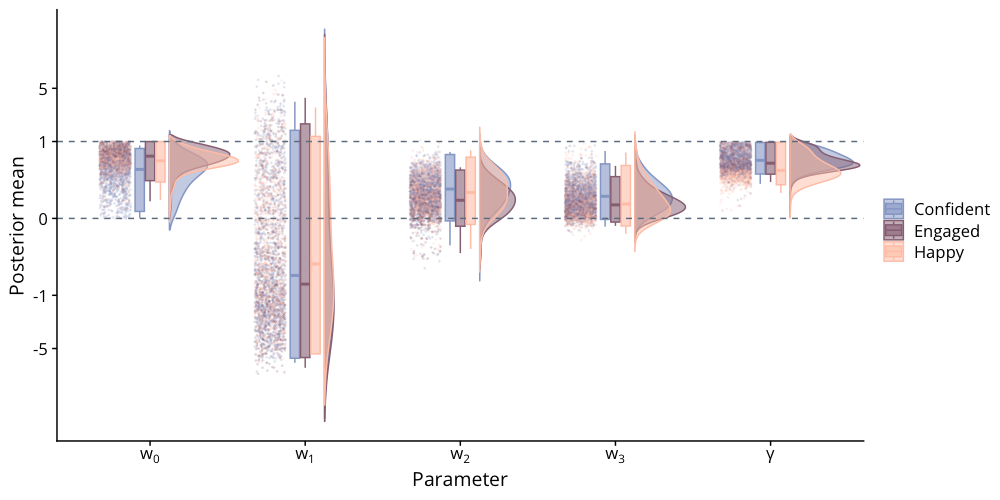

In [25]:
%%R -w 10 -h 5 --units in -r 100

wt_plt <- pstpipeline::plot_affect(
    pars, plt_type = "weights", pal = pal_contr, font = "Open Sans", 
    font_size = 14, legend_pos = "right"
)
wt_plt

Though we can see quite clearly the trends across both groups in baseline ratings ($w_0$), with engagement having the highest baseline rating, and confidence the lowest, it seems there are limited obvious between-group differences (explored further below).

## Parameter recovery

To see how well these models can recover known parameter values, we first simulate task data given parameters drawn from the distributions as given in the function arguments (either $Beta(\alpha, \beta)$ or $Normal(\mu, \sigma)$), and then re-fit the models using variational inference in the exact same manner as the models fit to data (with a strict convergence threshold).

Note that model fitting with variational inference to simulated data may require the below code to be run a number of times before convergence (mean/median change in ELBO = 0.005) is reached (as here). However, generally recovery is excellent even if this threshold is not reached after 15,000 iterations.

### Original model

In [26]:
%%R
# dir.create(file.path("outputs/cmdstan/affect_2a/simulated_data"))
affect_3wt_sim <- pstpipeline::simulate_QL(
    sample_size = 100,
    affect = TRUE,
    time_pars = "none",
    alpha_pos_dens = c(shape1 = 1.5, shape2 = 3),
    alpha_neg_dens = c(shape1 = 1.5, shape2 = 3),
    beta_dens = c(shape1 = 3, shape2 = 4),
    w0_dens = c(mean = 0, sd = 0.5),
    w2_dens = c(mean = 0.2, sd = 0.1),
    w3_dens = c(mean = 0.2, sd = 0.1),
    gamma_dens = c(shape1 = 2, shape2 = 2)
)
saveRDS(affect_3wt_sim, "outputs/cmdstan/affect_2a/simulated_data/affect_3wt_sim.RDS")

  |==============================================================================================================| 100%

In [27]:
%%R
vb_affect_3wt_sim <- pstpipeline::fit_learning_model(
    affect_3wt_sim$sim, model = "2a", exp_part = "training", par_recovery = TRUE, affect = TRUE, 
    affect_sfx = "3wt", vb = TRUE, ppc = TRUE, model_checks = FALSE, iter = 15000, 
    tol_rel_obj = 0.005, outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_2a/simulated_data/3wt"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.040012 seconds 
1000 transitions using 10 leapfrog steps per transition would take 400.12 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100       -63170.533             1.000            1.000 
   200       -24921.574             1.267            1.535 
   300       -13347.43

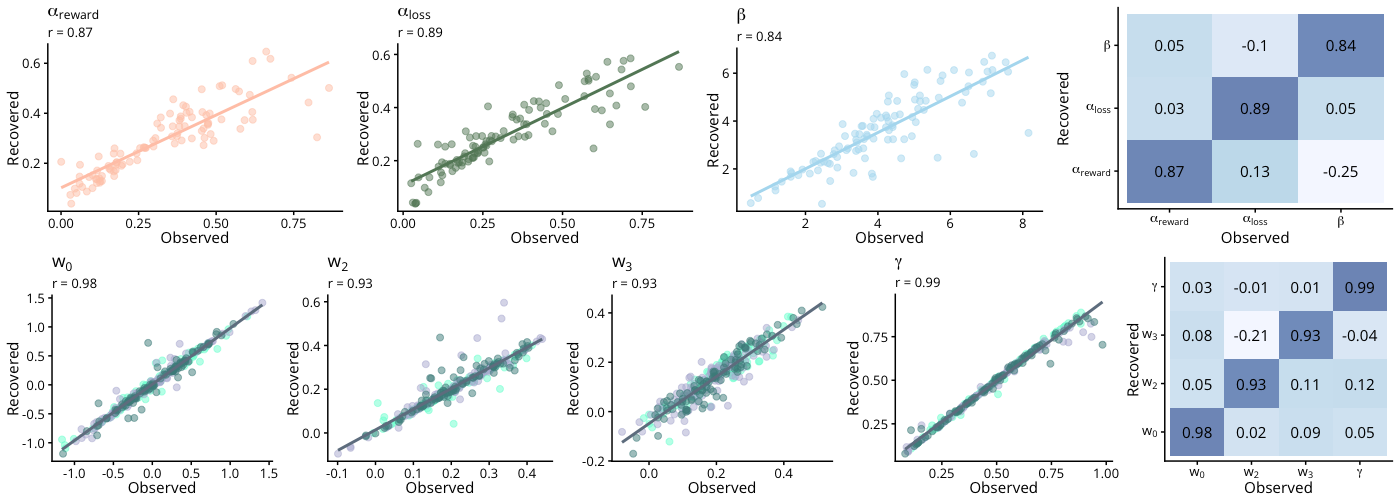

In [28]:
%%R -w 14 -h 5 --units in -r 100
recovery_plots <- list()

affect_3wt_sim <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/affect_3wt_sim.RDS"
)
affect_3wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/3wt/fit_pst_training_2a_vb_summary.RDS"
)

recovery_plots$affect_3wt <- pstpipeline::plot_recovery(
    affect_3wt_sim$pars, affect_3wt_sim_fitted, affect = TRUE, 
    alpha_par_nms = c("reward", "loss"), pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_3wt

### Affect drift over time model

In [29]:
%%R
affect_4wt_sim <- pstpipeline::simulate_QL(
    sample_size = 100,
    affect = TRUE,
    time_pars = "overall",
    alpha_pos_dens = c(shape1 = 1.5, shape2 = 3),
    alpha_neg_dens = c(shape1 = 1.5, shape2 = 3),
    beta_dens = c(shape1 = 3, shape2 = 4),
    w0_dens = c(mean = 0, sd = 0.5),
    w1_o_dens = c(mean = -0.5, sd = 1),
    w2_dens = c(mean = 0.2, sd = 0.1),
    w3_dens = c(mean = 0.2, sd = 0.1),
    gamma_dens = c(shape1 = 2, shape2 = 2)
)
saveRDS(affect_4wt_sim, "outputs/cmdstan/affect_2a/simulated_data/affect_4wt_sim.RDS")

  |==============================================================================================================| 100%

In [30]:
%%R
vb_affect_4wt_sim <- pstpipeline::fit_learning_model(
    affect_4wt_sim$sim, model = "2a", exp_part = "training", par_recovery = TRUE, affect = TRUE, 
    affect_sfx = "4wt_time", vb = TRUE, ppc = TRUE, model_checks = FALSE, iter = 15000, 
    tol_rel_obj = 0.005, outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_2a/simulated_data/4wt"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.039676 seconds 
1000 transitions using 10 leapfrog steps per transition would take 396.76 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -122485.525             1.000            1.000 
   200       -49201.806             1.245            1.489 
   300       -22289.84

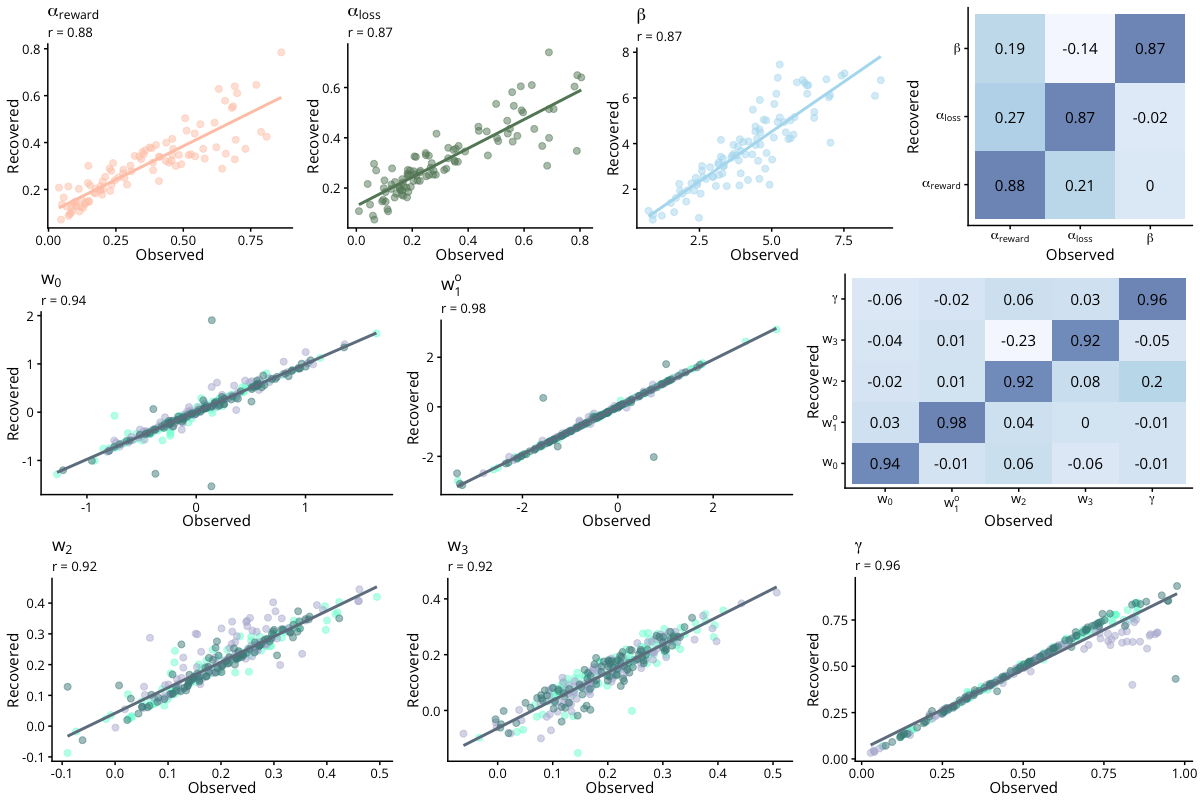

In [31]:
%%R -w 12 -h 8 --units in -r 100
affect_4wt_sim <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/affect_4wt_sim.RDS"
)
affect_4wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/4wt/fit_pst_training_2a_vb_summary.RDS"
)

recovery_plots$affect_4wt_time <- pstpipeline::plot_recovery(
    affect_4wt_sim$pars, affect_4wt_sim_fitted, affect = TRUE, 
    alpha_par_nms = c("reward", "loss"), pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_4wt_time

In all models, it appears that the $Q$-learning and affect model parameters are well-recovered by both the baseline and extended model (i.e., with time-dependent drift) investigated here, with low confusability.

## Between-rating RL-affect model

For this final analysis, we explore the effect of the treatments on trial-to-trial changes in affect ratings (of each type).

In [32]:
%%R
delta_mod_vb <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "delta", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/delta_model"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\| 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.162039 seconds 
1000 transitions using 10 leapfrog steps per transition would take 1620.39 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100   -814483914.299             1.000            1.000 
   200     -6062127.782           

### Compare to benchmark (winning model with $\gamma$)

In [33]:
%%R
pth    <- "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/"
pth_dl <- "outputs/cmdstan/affect_2a/all/model_fits/delta_model/"

loo_obj_og <- readRDS(paste0(pth, "fit_pst_training_2a_vb_loo_obj.RDS"))
loo_obj_dl <- readRDS(paste0(pth_dl, "fit_pst_training_2a_vb_loo_obj.RDS"))

aff_delta_comp <- loo::loo_compare(loo_obj_og, loo_obj_dl)
print(aff_delta_comp, digits = 1, simplify = FALSE)

       elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model1       0.0       0.0  238451.9    7837.5      8359.7     342.7 -476903.7   15675.0
model2  -23933.5    1735.5  214518.3    7165.5     10279.2     280.0 -429036.6   14330.9
 elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model1       0.0       0.0  238451.9    7837.5      8359.7     342.7 -476903.7   15675.0
model2  -23933.5    1735.5  214518.3    7165.5     10279.2     280.0 -429036.6   14330.9


In [34]:
%%R
draws_ls_dlt <- posterior::as_draws_df(
    readRDS(paste0(pth_dl, "fit_pst_training_2a_vb_draws_list.RDS"))
)
raw_df_dlt <- readRDS(paste0(pth_dl, "fit_pst_training_2a_vb_raw_df.RDS"))
summary_df_dlt <- readRDS(paste0(pth_dl,"fit_pst_training_2a_vb_summary.RDS"))
pars_dlt <- pstpipeline::make_par_df(raw_df_dlt, summary_df_dlt)

pars_summary <- pars_dlt |>
    dplyr::group_by(parameter, adj, outc_lag) |>
    dplyr::filter(subjID %in% unique(pars_dlt$subjID)) |>
    dplyr::summarise(
        n = dplyr::n(), 
        median = median(posterior_mean, na.rm = TRUE), 
        mean = mean(posterior_mean, na.rm = TRUE),
        sd = sd(posterior_mean),
        min = min(posterior_mean, na.rm = TRUE),
        max = max(posterior_mean, na.rm = TRUE),
        .groups = "keep"
    )
print(pars_summary, n=39)

# A tibble: 39 × 9
# Groups:   parameter, adj, outc_lag [39]
   parameter adj       outc_lag     n  median    mean     sd      min   max
   <chr>     <chr>        <dbl> <int>   <dbl>   <dbl>  <dbl>    <dbl> <dbl>
 1 alpha_neg <NA>            NA   935  0.134   0.148  0.0927  0.00100 0.632
 2 alpha_pos <NA>            NA   935  0.115   0.115  0.0129  0.0711  0.163
 3 beta      <NA>            NA   935  1.41    1.72   1.43    0.0510  8.02 
 4 w0        confident       NA   935 -0.355  -0.552  1.11   -4.75    3.34 
 5 w0        engaged         NA   935  0.544   0.582  0.887  -1.99    3.20 
 6 w0        happy           NA   935  0.182   0.239  0.809  -2.94    3.39 
 7 w1_o      confident       NA   935 -0.542  -0.744  1.57   -5.74    5.07 
 8 w1_o      engaged         NA   935 -0.713  -1.03   1.79   -9.15    5.00 
 9 w1_o      happy           NA   935 -0.438  -0.618  1.18   -4.71    3.60 
10 w2        confident        1   935  0.130   0.203  0.238  -0.319   2.31 
11 w2        confident     

In [35]:
%%R
# extract posterior predictions
fits <- list()
for (adj in c("happy", "confident", "engaged")) {
    fits[[adj]] <- pstpipeline::get_affect_ppc(draws_ls_dlt, raw_df_dlt, adj = adj)
}
saveRDS(fits, "outputs/cmdstan/affect_2a/fit_dfs_delta_mod.RDS")

  |==============================================================================================================| 100%

In [36]:
%%R
fits_all <- 
    dplyr::bind_rows(
        fits$happy$fit_df |> dplyr::mutate(adj = "happy"),
        fits$confident$fit_df |> dplyr::mutate(adj = "confident"),
        fits$engaged$fit_df |> dplyr::mutate(adj = "engaged")
    )
    
# library(rlang, quietly = TRUE, warn.conflicts = FALSE)
stats <- list()
for (stat in c("pseudo_R2", "MAE", "RMSE")) {
    s <- rlang::sym(stat)
    stats[[stat]] <- fits_all |> 
        dplyr::group_by(adj) |> 
        dplyr::summarise(
            n = dplyr::n(), 
            NAs = sum(is.na(!!s)), 
            median = median(!!s, na.rm = TRUE), 
            mean = mean(!!s, na.rm = TRUE),
            sd = sd(!!s, na.rm = TRUE),
            min = min(!!s, na.rm = TRUE),
            max = max(!!s, na.rm = TRUE),
            .groups = "keep"
        )
}
stats

$pseudo_R2
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd        min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl>      <dbl> <dbl>
1 confident   935     3  0.366 0.391 0.221 0.000295   0.933
2 engaged     935     3  0.357 0.389 0.249 0.00000247 0.968
3 happy       935     2  0.365 0.392 0.218 0.00714    0.904

$MAE
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd   min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl> <dbl> <dbl>
1 confident   935     0   7.40  8.23  4.33 0.592  38.1
2 engaged     935     0   7.32  8.40  4.62 0.925  33.8
3 happy       935     0   6.75  7.53  4.22 0.897  33.9

$RMSE
# A tibble: 3 × 8
# Groups:   adj [3]
  adj           n   NAs median  mean    sd   min   max
  <chr>     <int> <int>  <dbl> <dbl> <dbl> <dbl> <dbl>
1 confident   935     0   9.85 10.6   5.02 0.604  40.7
2 engaged     935     0   9.42 10.6   5.34 1.18   37.1
3 happy       935     0   8.69  9.53  4.92 1.12   36.8



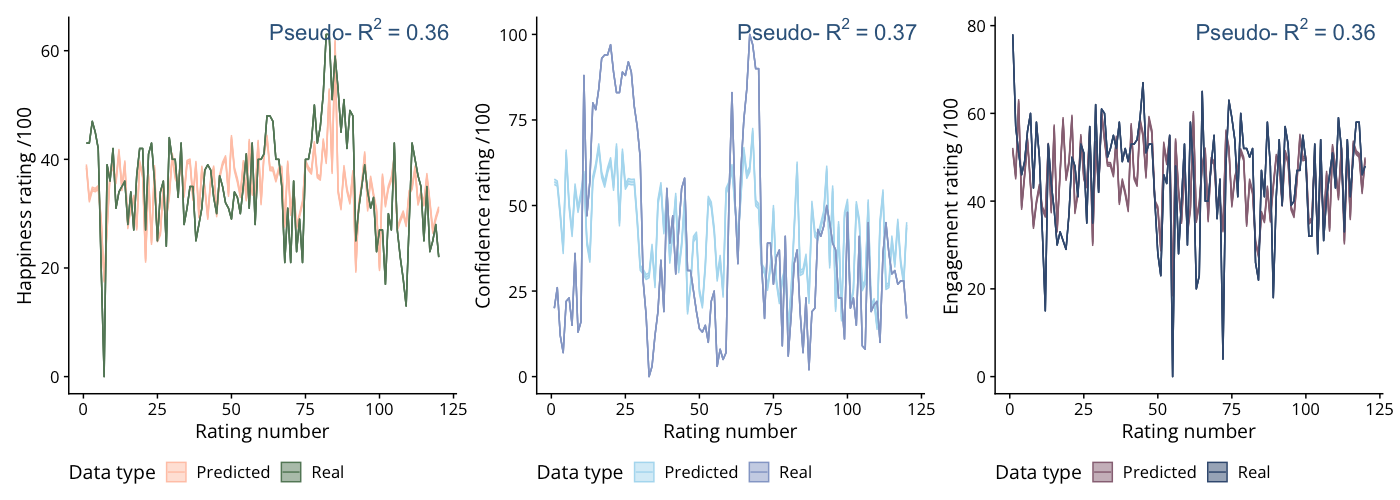

In [37]:
%%R -w 14 -h 5 --units in -r 100
# library(patchwork)
med_plts <- pstpipeline::plot_affect(
  fits, plt_type = "individual", font = "Open Sans", 
  font_size = 14, legend_pos = "bottom", r2_coords = c(0.75, 0.97)
)
med_plts$happy + med_plts$confident + med_plts$engaged

### Parameter recovery

In [38]:
%%R
aff_delta_sim <- pstpipeline::simulate_QL(
  sample_size = 100,
  gamma_dens = c(shape1 = 4, shape2 = 2),
  affect = TRUE,
  delta_model = TRUE,
  time_pars = "overall"
)
saveRDS(aff_delta_sim, "outputs/cmdstan/affect_2a/simulated_data/aff_delta_sim.RDS")

  |==============================================================================================================| 100%

In [39]:
%%R
vb_affect_dlt <- pstpipeline::fit_learning_model(
  aff_delta_sim$sim, model = "2a", exp_part = "training", par_recovery = TRUE, affect = TRUE,
  affect_sfx = "delta", vb = TRUE, ppc = TRUE, model_checks = FALSE, iter = 15000,
  tol_rel_obj = 0.005, outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
  out_dir = "outputs/cmdstan/affect_2a/simulated_data/delta_model/"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.017466 seconds 
1000 transitions using 10 leapfrog steps per transition would take 174.66 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.017466 seconds 
1000 transitions using 10 leapfrog steps per transition would take 174.66 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 25

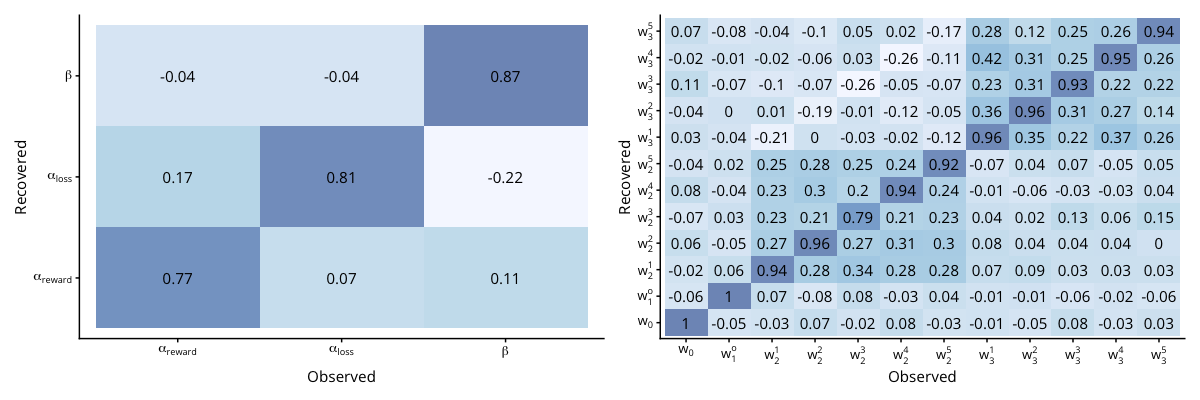

In [40]:
%%R -w 12 -h 4 --units in -r 100
library(patchwork)
plts <- pstpipeline::plot_recovery(
  aff_delta_sim$pars, vb_affect_dlt$summary, affect = TRUE,
  alpha_par_nms = c("reward", "loss"), pal = pal_recovery, font = "Open Sans",
  plot_together = FALSE
)
plts$heatmaps$ql + plts$heatmaps$wts